In [44]:
import slax as sl
import os
#os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"
#import flax.linen as nn
from flax import nnx
import jax.numpy as jnp
import jax
import optax
import pickle
from jax.tree_util import tree_map, Partial, tree_leaves, tree_structure, tree_unflatten
import matplotlib.pyplot as plt
from functools import partial

In [1]:
import numpy as np

In [22]:
a = np.load('/Users/thomas/Downloads/spyx_xla_0.npy')

In [26]:
a[2,0,0]

np.float64(3.9083370685577394)

In [45]:
input_sz = 64
output_sz = 10
seq_len = 50
manifold_key = jax.random.PRNGKey(0)
random_seed = manifold_key
key = manifold_key
batch_sz = 32
dtype = jnp.float32
n_steps = 5000
nnx_key = nnx.Rngs(0)

In [46]:
# import jax
# import jax.numpy as jnp
# import flax.linen as nn
# from flax import nnx
# from typing import Any, Sequence
# from jax.tree_util import Partial, tree_leaves, tree_map
# from jax.lax import stop_gradient as stop_grad
# from jax.flatten_util import ravel_pytree
# from slax.models.utils import reinit_model, connect, RNN
# from slax.train.helpers import output, sum_output, diag, rtrl_update
# from functools import partial

# def diag_rtrl_update(a,b,c):
#     def custom_mul(x,y):
#         if len(y.shape) == 3:
#             return jnp.einsum('...ibj,bij->b...j',x,y)
#         else:
#             print(x.shape)
#             print(y.shape)
#             return jnp.einsum('...jbi,bjki->b...ki',x,y)
#     return jax.tree.map(lambda x,y: custom_mul(a,x)+y,b,c)


# class diag_rtrl(nnx.Module):
#     def __init__(self, mdl, batch_sz, diagonal_sum=True):
#         self.mdl = mdl
#         graph,param,state = nnx.split(mdl,nnx.Param,...)
#         E = [jax.tree.map(jnp.zeros_like,param)]*len(jax.tree.leaves(state))
#         self.E = nnx.Variable(jax.tree.map(lambda *args: jnp.stack(batch_sz*[jnp.stack(args)]),*E))
#         self.diagonal_sum = diagonal_sum
#     @nnx.jit
#     def __call__(self,x):
#         @jax.custom_vjp
#         def exec_model(graph,param,state,E,x):
#             model = nnx.merge(graph,param,state)
#             out = model(x)
#             return out, nnx.split(model,nnx.Param,...)[2], E
        
#         def exec(graph,param,state,E,x):
#             if self.diagonal_sum:
#                 ((ds_dp,ds_du),(du_dp,du_du)),(out,state,f_vjp) = jax.jacrev(sum_output,argnums=[1,2],has_aux=True)(graph,param,state,x)
#             else:
#                 grads,(out,state,f_vjp) = jax.jacrev(output,argnums=[1,2],has_aux=True)(graph,param,state,x)
#                 (ds_grad),(du_dp,du_du) = jax.tree.map(diag,grads)
#                 ds_dp,ds_du = jax.tree.map(lambda x: x[0],ds_grad)
            
#             ds_du, du_du = jnp.stack(jax.tree.leaves(ds_du)), jnp.stack(jax.tree.leaves(du_du))
#             #print(du_du)
        
#             ds_dtheta = diag_rtrl_update(ds_du,E,ds_dp)

#             print(ds_dtheta)
#             E = diag_rtrl_update(du_du,E,du_dp)
#             #print(E)

#             return (out,state,E), (ds_dtheta,f_vjp)

#         def exec_bwd(res,g):
#             ds_dtheta,f_vjp = res
#             grad = jax.tree.map(lambda x: jnp.einsum('bj,b...j->...j',g[0],x),ds_dtheta)
#             passback = jax.tree.leaves(f_vjp(g[0]))[0]
#             #print(grad)
#             return (None,grad,None,None,passback)

#         exec_model.defvjp(exec, exec_bwd)
#         graph, param, state = nnx.split(self.mdl,nnx.Param,...)
#         #vp_exec = partial(jax.vmap(partial(exec_model,graph,param)),state,self.E.value)
#         if len(x.shape)<2:
#             x = x.reshape(1,-1)
#         #out,state,E = vp_exec(x)
#         out,state,E = exec_model(graph,param,state,self.E.value,x)
#         self.E.value = E
#         nnx.update(self.mdl,state)
#         return out

In [47]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax import nnx
from typing import Any, Sequence
from jax.tree_util import Partial, tree_leaves, tree_map
from jax.lax import stop_gradient as stop_grad
from jax.flatten_util import ravel_pytree
from slax.models.utils import reinit_model, connect, RNN
from slax.train.helpers import output, sum_output, diag, rtrl_update, diag_rtrl_update
from functools import partial

class diag_rtrl(nnx.Module):
    def __init__(self, mdl, batch_sz, diagonal_sum=True):
        self.mdl = mdl
        graph,param,state = nnx.split(mdl,nnx.Param,...)
        E = [jax.tree.map(jnp.zeros_like,param)]*len(jax.tree.leaves(state))
        self.E = nnx.Variable(jax.tree.map(lambda *args: jnp.stack(batch_sz*[jnp.stack(args)]),*E))
        self.diagonal_sum = diagonal_sum
    @nnx.jit
    def __call__(self,x):
        @jax.custom_vjp
        def exec_model(graph,param,state,E,x):
            model = nnx.merge(graph,param,state)
            out = model(x)
            return out, nnx.split(model,nnx.Param,...)[2], E
        
        def exec(graph,param,state,E,x):
            if self.diagonal_sum:
                ((ds_dp,ds_du),(du_dp,du_du)),(out,state,f_vjp) = jax.jacrev(sum_output,argnums=[1,2],has_aux=True)(graph,param,state,x)
            else:
                grads,(out,state,f_vjp) = jax.jacrev(output,argnums=[1,2],has_aux=True)(graph,param,state,x)
                (ds_grad),(du_dp,du_du) = jax.tree.map(diag,grads)
                ds_dp,ds_du = jax.tree.map(lambda x: x[0],ds_grad)
            
            ds_du, du_du = jnp.stack(jax.tree.leaves(ds_du)), jnp.stack(jax.tree.leaves(du_du))
        
            ds_dtheta = diag_rtrl_update(ds_du,E,ds_dp)
            E = diag_rtrl_update(du_du,E,du_dp)
            #print(self.E)
            #print(E)
            #self.E.value = E

            return (out,state,E), (ds_dtheta,f_vjp)

        def exec_bwd(res,g):
            ds_dtheta,f_vjp = res
            grad = jax.tree.map(lambda x: g[0]*x,ds_dtheta)
            passback = jax.tree.leaves(f_vjp(g[0]))[0]
            #print(g)
            return (None,grad,None,None,passback)
        
        exec_model.defvjp(exec, exec_bwd)
        graph, param, state = nnx.split(self.mdl,nnx.Param,...)
        vp_exec = partial(jax.vmap(partial(exec_model,graph,param)),state,self.E.value)
        if len(x.shape)<2:
            x = x.reshape(1,-1)
        try:
            out,state,E = vp_exec(x)
        except:
            vp_exec = partial(jax.vmap(partial(exec_model,graph,param,state)),self.E.value)
            out,state,E = vp_exec(x)
        self.E.value = E
        nnx.update(self.mdl,state)
        return out

In [48]:
# import jax
# import jax.numpy as jnp
# import flax.linen as nn
# from flax import nnx
# from typing import Any, Sequence
# from jax.tree_util import Partial, tree_leaves, tree_map
# from jax.lax import stop_gradient as stop_grad
# from jax.flatten_util import ravel_pytree
# from slax.models.utils import reinit_model, connect, RNN
# from slax.train.helpers import output, sum_output, diag, rtrl_update, diag_rtrl_update
# from functools import partial

# class diag_rtrl(nnx.Module):
#     def __init__(self, mdl, input, diagonal_sum=True):
#         self.mdl = mdl
#         graph,param,state = nnx.split(mdl,nnx.Param,...)
#         E = [jax.tree.map(lambda x: jnp.zeros(x.size),param)]*len(jax.tree.leaves(state))
#         #self.E = nnx.Variable(jax.tree.map(lambda *args: jnp.stack(batch_sz*[jnp.stack(args)]),*E))
#         self.E = nnx.Variable(jax.tree.map(lambda *args: jnp.stack(args),*E))
#         self.diagonal_sum = diagonal_sum
#     @nnx.jit
#     def __call__(self,x):
#         @jax.custom_vjp
#         def exec_model(graph,param,state,E,x):
#             model = nnx.merge(graph,param,state)
#             out = model(x)
#             return out, nnx.split(model,nnx.Param,...)[2], E
        
#         def exec(graph,param,state,E,x):
#             if self.diagonal_sum:
#                 ((ds_dp,ds_du),(du_dp,du_du)),(out,state,f_vjp) = jax.jacrev(sum_output,argnums=[1,2],has_aux=True)(graph,param,state,x)
#             else:
#                 grads,(out,state,f_vjp) = jax.jacrev(output,argnums=[1,2],has_aux=True)(graph,param,state,x)
#                 (ds_grad),(du_dp,du_du) = jax.tree.map(diag,grads)
#                 ds_dp,ds_du = jax.tree.map(lambda x: x[0],ds_grad)
            
#             #print(du_du)
#             #print(ds_du)
#             ds_du, du_du = jnp.stack(jax.tree.leaves(ds_du)), jnp.stack(jax.tree.leaves(du_du))
        
#             ds_dtheta = diag_rtrl_update(ds_du,E,ds_dp)
#             E = diag_rtrl_update(du_du,E,du_dp)

#             return (out,state,E), (ds_dtheta,f_vjp)

#         def exec_bwd(res,g):
#             ds_dtheta,f_vjp = res
#             grad = jax.tree.map(lambda x: g[0]*x,ds_dtheta)
#             passback = jax.tree.leaves(f_vjp(g[0]))[0]
#             return (None,grad,None,None,passback)
        
#         exec_model.defvjp(exec, exec_bwd)
#         graph, param, state = nnx.split(self.mdl,nnx.Param,...)
#         vp_exec = partial(jax.vmap(partial(exec_model,graph,param)),state,self.E.value)
#         if len(x.shape)<2:
#             x = x.reshape(1,-1)
#         #try:
#         out,state,E = exec_model(graph,param,state,self.E.value,x)
#         # except:
#         #     vp_exec = partial(jax.vmap(partial(exec_model,graph,param,state)),self.E.value)
#         #     out,state,E = vp_exec(x)
#         self.E.value = E
#         nnx.update(self.mdl,state)
#         return out

In [49]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
from flax import nnx
from typing import Any, Sequence
from jax.tree_util import Partial, tree_leaves, tree_map
from jax.lax import stop_gradient as stop_grad
from jax.flatten_util import ravel_pytree
from slax.models.utils import reinit_model, connect, RNN
from slax.train.helpers import output, sum_output, diag, rtrl_update, diag_rtrl_update
from functools import partial

def map_stack(x,len_state):
    p_sum = lambda x,y: jnp.sum(x,axis=list(range(-1,-y -1,-1)))
    out = jnp.stack(jax.tree.leaves(jax.tree.map(p_sum,x,len_state)))
    #print(out)
    return out

def map_stack2(x,len_state):
    p_sum = lambda y: jnp.sum(x,axis=list(range(-1,-y -1,-1)))
    out = jnp.stack(jax.tree.leaves(jax.tree.map(p_sum,len_state)))
    #print(out)
    return out

def sum_last(x):
    return jnp.stack(jax.tree.leaves(jax.tree.map(partial(jnp.sum,axis=-1),(x,))))

def sum_output(graph,param,state,x):
    len_state = jax.tree.map(lambda x: len(x.shape),state)
    def forward(x):
        model = nnx.merge(graph,param,state)
        out = model(x)
        return out, nnx.split(model,nnx.Param,...)[2]
    (out,f_vjp,state) = jax.vjp(forward,x,has_aux=True)
    return (sum_last(out),sum_last(state),map_stack2(out,len_state),map_stack(state,len_state)),(out,state,f_vjp)

def d_sum(a,b):
    l = len(a.shape)
    return jnp.einsum(a,list(range(l)),b,[0]+list(range(2,l-1))+[Ellipsis]+[l-1],list(range(1,l-1))+[Ellipsis]+[l-1])

def d2_sum(a,b):
    l = len(a.shape)
    out = jnp.einsum(a,list(range(l)),b,list(range(l-1))+[Ellipsis]+[l-1],[Ellipsis]+[l-1])
    return out

def diag_rtrl_update(x,y,z):
    b = jax.tree.map(lambda r,t: r+0*t,y,z)
    out = jax.tree.map(lambda inp, ds: d_sum(x,inp) + ds,b,z)
    return out

def calc_grad(x,y):
    out = jax.tree.map(lambda inp: d2_sum(x,inp),y)
    return out

def calc_E(state,params):
    shape = jnp.stack(jax.tree.leaves(state)).shape[:-1]
    E = jax.tree.map(lambda x: jnp.zeros(shape + x.shape),params)
    return E


class diag_rtrl(nnx.Module):
    def __init__(self, mdl, diagonal_sum=True):
        self.mdl = mdl
        graph,param,state = nnx.split(mdl,nnx.Param,...)
        self.E = nnx.Variable(jax.tree.map(lambda x: jnp.array([0.],dtype=x.dtype),param))
        self.diagonal_sum = diagonal_sum
    @nnx.jit
    def __call__(self,x):
        @jax.custom_vjp
        def exec_model(graph,param,state,E,x):
            model = nnx.merge(graph,param,state)
            out = model(x)
            state = nnx.split(model,nnx.Param,...)[2]
            E = calc_E(state,param)
            return out, state, E
        #@jax.jit
        def exec(graph,param,state,E,x):
            if self.diagonal_sum:
                ((ds_dp,_),(du_dp,_),(_,ds_du),(_,du_du)),(out,state,f_vjp) = jax.jacrev(sum_output,argnums=[1,2],has_aux=True)(graph,param,state,x)
            else:
                grads,(out,state,f_vjp) = jax.jacrev(output,argnums=[1,2],has_aux=True)(graph,param,state,x)
                (ds_grad),(du_dp,du_du) = jax.tree.map(diag,grads)
                ds_dp,ds_du = jax.tree.map(lambda x: x[0],ds_grad)
            
            ds_du, du_du = jnp.stack(jax.tree.leaves(ds_du)), jnp.stack(jax.tree.leaves(du_du))
        
            ds_dtheta = diag_rtrl_update(ds_du,E,ds_dp)
            E = diag_rtrl_update(du_du,E,du_dp)
            return (out,state,E), (ds_dtheta,f_vjp)

        def exec_bwd(res,g):
            ds_dtheta,f_vjp = res
            gr = jnp.stack(jax.tree.leaves((g[0],)))
            grad = calc_grad(gr,ds_dtheta)
            passback = jax.tree.leaves(f_vjp(g[0]))[0]

            return (None,grad,None,None,passback)
        
        exec_model.defvjp(exec, exec_bwd)
        graph, param, state = nnx.split(self.mdl,nnx.Param,...)
        out,state,E = exec_model(graph,param,state,self.E.value,x)
        self.E.value = E
        nnx.update(self.mdl,state)
        return out

In [50]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
from flax import nnx
from typing import Any, Sequence
from jax.tree_util import Partial, tree_leaves, tree_map
from jax.lax import stop_gradient as stop_grad
from jax.flatten_util import ravel_pytree
from slax.models.utils import reinit_model, connect, RNN
from slax.train.helpers import output, sum_output, diag, rtrl_update, diag_rtrl_update
from functools import partial

def map_stack(x,len_state):
    p_sum = lambda x,y: jnp.sum(x,axis=list(range(-1,-y -1,-1)))
    out = jnp.stack(jax.tree.leaves(jax.tree.map(p_sum,x,len_state)))
    return out

def map_stack2(x,len_state):
    p_sum = lambda y: jnp.sum(x,axis=list(range(-1,-y -1,-1)))
    out = jnp.stack(jax.tree.leaves(jax.tree.map(p_sum,len_state)))
    return out

def sum_last(x):
    return jnp.stack(jax.tree.leaves(jax.tree.map(partial(jnp.sum,axis=-1),(x,))))

def sum_output(graph,param,state,x):
    len_state = jax.tree.map(lambda x: len(x.shape),state)
    def forward(x):
        model = nnx.merge(graph,param,state)
        out = model(x)
        return out, nnx.split(model,nnx.Param,...)[2]
    (out,f_vjp,state) = jax.vjp(forward,x,has_aux=True)
    return (sum_last(out),sum_last(state),map_stack2(out,len_state),map_stack(state,len_state)),(out,state,f_vjp)

def d_sum(a,b):
    l = len(a.shape)
    print('here')
    l1 = list(range(l))
    l2 = [0]+list(range(2,l-1))+[Ellipsis]+[l-1]
    l3 = list(range(1,l-1))+[Ellipsis]+[l-1]
    print(l1,l2,l3)
    return jnp.einsum(a,list(range(l)),b,[0]+list(range(2,l-1))+[Ellipsis]+[l-1],list(range(1,l-1))+[Ellipsis]+[l-1])

def d2_sum(a,b):
    l = len(a.shape)
    print('there')
    out = jnp.einsum(a,list(range(l)),b,list(range(l-1))+[Ellipsis]+[l-1],[Ellipsis]+[l-1])
    return out

def diag_rtrl_update(x,y,z):
    b = jax.tree.map(lambda r,t: r+0*t,y,z)
    out = jax.tree.map(lambda inp, ds: d_sum(x,inp) + ds,b,z)
    return out

def calc_grad(x,y):
    out = jax.tree.map(lambda inp: d2_sum(x,inp),y)
    return out

def calc_E(state,params):
    shape = jnp.stack(jax.tree.leaves(state)).shape[:-1]
    E = jax.tree.map(lambda x: jnp.zeros(shape + x.shape),params)
    return E


class diag_rtrl(nnx.Module):
    def __init__(self, mdl, diagonal_sum=True):
        self.mdl = mdl
        graph,param,state = nnx.split(mdl,nnx.Param,...)
        self.E = nnx.Variable(jax.tree.map(lambda x: jnp.array([0.],dtype=x.dtype),param))
        self.diagonal_sum = diagonal_sum
    @nnx.jit
    def __call__(self,x):
        @jax.custom_vjp
        def exec_model(graph,param,state,E,x):
            model = nnx.merge(graph,param,state)
            out = model(x)
            state = nnx.split(model,nnx.Param,...)[2]
            E = calc_E(state,param)
            return out, state, E
        #@jax.jit
        def exec(graph,param,state,E,x):
            if self.diagonal_sum:
                ((ds_dp,_),(du_dp,_),(_,ds_du),(_,du_du)),(out,state,f_vjp) = jax.jacrev(sum_output,argnums=[1,2],has_aux=True)(graph,param,state,x)
            else:
                grads,(out,state,f_vjp) = jax.jacrev(output,argnums=[1,2],has_aux=True)(graph,param,state,x)
                (ds_grad),(du_dp,du_du) = jax.tree.map(diag,grads)
                ds_dp,ds_du = jax.tree.map(lambda x: x[0],ds_grad)
            
            ds_du, du_du = jnp.stack(jax.tree.leaves(ds_du)), jnp.stack(jax.tree.leaves(du_du))
        
            ds_dtheta = diag_rtrl_update(ds_du,E,ds_dp)
            E = diag_rtrl_update(du_du,E,du_dp)
            return (out,state,E), (ds_dtheta,f_vjp)

        def exec_bwd(res,g):
            ds_dtheta,f_vjp = res
            gr = jnp.stack(jax.tree.leaves((g[0],)))
            grad = calc_grad(gr,ds_dtheta)
            passback = jax.tree.leaves(f_vjp(g[0]))[0]

            return (None,grad,None,None,passback)
        
        exec_model.defvjp(exec, exec_bwd)
        graph, param, state = nnx.split(self.mdl,nnx.Param,...)
        out,state,E = exec_model(graph,param,state,self.E.value,x)
        self.E.value = E
        nnx.update(self.mdl,state)
        return out

In [ ]:
class OTTT(nnx.Module):
    def __init__(self, mdl, diagonal_sum=True):
        self.mdl = mdl
        graph,param,state = nnx.split(mdl,nnx.Param,...)
        self.E = nnx.Variable(jax.tree.map(lambda x: jnp.array([0.],dtype=x.dtype),param))
        self.diagonal_sum = diagonal_sum
    @nnx.jit
    def __call__(self,x):
        @jax.custom_vjp
        def exec_model(graph,param,state,E,x):
            model = nnx.merge(graph,param,state)
            out = model(x)
            state = nnx.split(model,nnx.Param,...)[2]
            E = calc_E(state,param)
            return out, state, E
        #@jax.jit
        def exec(graph,param,state,E,x):
            if self.diagonal_sum:
                ((ds_dp,_),(du_dp,_),(_,ds_du),(_,du_du)),(out,state,f_vjp) = jax.jacrev(sum_output,argnums=[1,2],has_aux=True)(graph,param,state,x)
            else:
                grads,(out,state,f_vjp) = jax.jacrev(output,argnums=[1,2],has_aux=True)(graph,param,state,x)
                (ds_grad),(du_dp,du_du) = jax.tree.map(diag,grads)
                ds_dp,ds_du = jax.tree.map(lambda x: x[0],ds_grad)
            
            ds_du, du_du = jnp.stack(jax.tree.leaves(ds_du)), jnp.stack(jax.tree.leaves(du_du))
        
            ds_dtheta = diag_rtrl_update(ds_du,E,ds_dp)
            E = diag_rtrl_update(du_du,E,du_dp)
            return (out,state,E), (ds_dtheta,f_vjp)

        def exec_bwd(res,g):
            ds_dtheta,f_vjp = res
            gr = jnp.stack(jax.tree.leaves((g[0],)))
            grad = calc_grad(gr,ds_dtheta)
            passback = jax.tree.leaves(f_vjp(g[0]))[0]

            return (None,grad,None,None,passback)
        
        exec_model.defvjp(exec, exec_bwd)
        graph, param, state = nnx.split(self.mdl,nnx.Param,...)
        out,state,E = exec_model(graph,param,state,self.E.value,x)
        self.E.value = E
        nnx.update(self.mdl,state)
        return out

In [51]:
batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,dtype=dtype)

In [52]:
snn = sl.connect([nnx.Linear(64,100,rngs=nnx_key),
                  sl.LIF(100),
                  nnx.Linear(100,100,rngs=nnx_key),
                  sl.LIF(100),
                  nnx.Linear(100,100,rngs=nnx_key),
                  sl.LIF(100)],cat={4:[1,2],2:[3]})

In [53]:
snn(jnp.zeros_like(batch[0][0]));

In [54]:
l1 = sl.connect([nnx.Linear(64,100,rngs=nnx_key),
                  sl.LIF(100)])
l2 = sl.connect([nnx.Linear(100,100,rngs=nnx_key),
                  sl.LIF(100)])
l3 = sl.connect([nnx.Linear(100,10,rngs=nnx_key),
                  sl.LIF(10)])
snn = sl.connect([l1,l2,l3])

In [55]:
x = jax.random.truncated_normal(jax.random.PRNGKey(0),-0.5,2.,(20,32,64))

In [56]:
import optax

In [57]:
optax.adam(0.001)

GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x158abdee0>, update=<function chain.<locals>.update_fn at 0x158abe020>)

In [58]:
snn = sl.connect([nnx.Linear(64,10,rngs=nnx.Rngs(0)),#nnx_key),
                  sl.LIF(10)])
#snn(jnp.zeros_like(batch[0][0]))
g,p = nnx.split(snn)

In [59]:
#graph1,p1,s1 = nnx.split(snn,nnx.Param,...)

In [60]:
batch[0].shape

(50, 32, 64)

In [61]:
l1 = sl.connect([nnx.Conv(64,100,2,rngs=nnx.Rngs(0)),
                  sl.LIF(100)])

In [62]:
l1 = sl.diag_rtrl(l1)

In [63]:
#l1(batch[0]).shape

In [64]:
@nnx.grad
def loss(snn):
    snn(batch[0])
    return jnp.sum(snn(batch[0]))

In [65]:
nnx.jit(loss)(l1)

here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
there
there
there
there


XlaRuntimeError: UNKNOWN: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_70667/247473262.py:4:19: error: failed to legalize operation 'mhlo.dot_general'
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_70667/247473262.py:4:19: note: called from
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_70667/3462137631.py:1:0: note: called from
<frozen runpy>:88:4: note: called from
<frozen runpy>:198:11: note: called from
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_70667/247473262.py:4:19: note: see current operation: %667 = "mhlo.dot_general"(%1, %613) {dot_dimension_numbers = #mhlo.dot<lhs_batching_dimensions = [3], rhs_batching_dimensions = [3], lhs_contracting_dimensions = [0, 1, 2], rhs_contracting_dimensions = [0, 1, 2]>} : (tensor<1x50x32x100xf32>, tensor<1x50x32x100xf32>) -> tensor<100xf32>


In [23]:
loss(l1)

here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
here
[0, 1, 2, 3, 4] [0, 2, 3, Ellipsis, 4] [1, 2, 3, Ellipsis, 4]
there
there


State({
  'mdl': {
    'chain': {
      0: {
        'bias': VariableState(
          type=Param,
          value=Array([36.859505, 34.669376, 42.61126 , 35.8621  , 53.016445, 53.236927,
                 37.213726, 31.184767, 31.964853, 49.11505 , 44.383484, 42.263897,
                 50.154522, 49.15603 , 42.22688 , 49.03219 , 36.944378, 41.569527,
                 41.223507, 31.440027, 35.446568, 44.250008, 41.529305, 79.44324 ,
                 35.325672, 41.03851 , 33.03958 , 54.344788, 45.67574 , 32.7691  ,
                 66.08645 , 46.1172  , 43.919514, 57.4566  , 38.971127, 47.911144,
                 46.625263, 21.642653, 39.134327, 28.507574, 66.46318 , 66.53866 ,
                 40.005962, 32.81882 , 40.212605, 43.32193 , 34.516582, 55.11848 ,
                 53.292496, 62.50898 , 33.44934 , 35.594994, 44.201965, 40.968525,
                 60.474503, 38.183308, 25.913815, 50.615295, 36.270576, 45.56291 ,
                 67.97275 , 42.040436, 52.78253 , 35.03741 , 28.56

In [288]:
l1 = sl.connect([nnx.Linear(64,100,rngs=nnx_key),
                  sl.LIF(100)])
l2 = sl.connect([nnx.Linear(100,100,rngs=nnx_key),
                  sl.LIF(100)])
l3 = sl.connect([nnx.Linear(100,10,rngs=nnx_key),
                  sl.LIF(10)])
snn = sl.connect([l1,l2,l3])

In [289]:
gr1,s1 = nnx.split(l1)
gr2,s2 = nnx.split(l2)
gr3,s3 = nnx.split(l3)

In [290]:
#batch = (x,batch[1])

In [291]:
train_step = sl.train_offline(snn,optax.softmax_cross_entropy,optax.adam(0.01))

In [292]:
for i in range(5):
    train_step(batch)
    batch = sl.randman(manifold_key,random_seed+i+1,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,dtype=dtype)

In [293]:
gr1,s1 = nnx.split(snn.chain[0])
gr2,s2 = nnx.split(snn.chain[1])
gr3,s3 = nnx.split(snn.chain[2])

In [294]:
train_step = sl.train_offline(snn,optax.softmax_cross_entropy,optax.adam(0.001))

In [295]:
train_step(batch)

In [296]:
g1 = train_step.grad

In [297]:
l1 = nnx.merge(gr1,s1)
l2 = nnx.merge(gr2,s2)
l3 = nnx.merge(gr3,s3)
snn = sl.connect([l1,l2,l3])

train_step = sl.train_online_deferred(snn,optax.softmax_cross_entropy,optax.adam(0.001))
train_step(batch)
g3 = train_step.grad

In [298]:
l1 = diag_rtrl(nnx.merge(gr1,s1),batch_sz)
l2 = diag_rtrl(nnx.merge(gr2,s2),batch_sz)
l3 = diag_rtrl(nnx.merge(gr3,s3),batch_sz)
snn = sl.connect([l1,l2,l3])

In [299]:
@nnx.grad
def loss(snn):
    return jnp.sum(snn(batch[0][0]))

In [300]:
#snn(batch[0][0])

In [301]:
#snn.chain[0].E

In [302]:
#loss(snn)

In [303]:
# mdl = sl.connect([nnx.Linear(64,10,rngs=nnx_key),
#                   sl.LIF(10)])
# g,p = nnx.split(mdl)
#snn = diag_rtrl(nnx.merge(g,p),32,True)
#snn(jnp.zeros_like(batch[0][0]))

In [304]:
#g,p,s = nnx.split(snn,nnx.Param,...)
#snn = nnx.merge(g,p,s)

In [305]:
train_step = sl.train_online_deferred(snn,optax.softmax_cross_entropy,optax.adam(0.001))

In [306]:
train_step(batch)

In [307]:
g2 = train_step.grad

In [308]:
ostl_alignment = sl.layerwise_cosine_similarity(jax.tree.leaves(g1),jax.tree.leaves(g2))

In [309]:
bp_alignment = sl.layerwise_cosine_similarity(jax.tree.leaves(g1),jax.tree.leaves(g3))

In [310]:
ostl_alignment[1::2]

[Array(0.771285, dtype=float32),
 Array(0.998138, dtype=float32),
 Array(1., dtype=float32)]

In [311]:
bp_alignment[1::2]

[Array(0.3779749, dtype=float32),
 Array(0.767234, dtype=float32),
 Array(0.9948083, dtype=float32)]

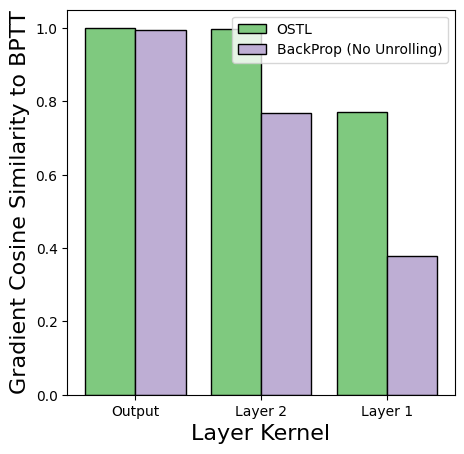

In [312]:
plt.figure(figsize=(5,5))
plt.bar([0.05,1.05,2.05],ostl_alignment[1::2][::-1],0.4,color='#7fc97f',edgecolor='k')
plt.bar([0.45,1.45,2.45],bp_alignment[1::2][::-1],0.4,color='#beaed4',edgecolor='k')
plt.xticks([0.25,1.25,2.25],['Output','Layer 2','Layer 1'])
plt.xlabel('Layer Kernel',fontsize=16)
plt.ylabel('Gradient Cosine Similarity to BPTT',fontsize=16)
plt.legend(['OSTL','BackProp (No Unrolling)'])

In [313]:
@nnx.jit
@nnx.grad
def loss(mdl,x):
    return jnp.sum(mdl(x))

In [314]:
jnp.sum(jax.tree.leaves(ostl.E.value)[1])

NameError: name 'ostl' is not defined

In [438]:
loss(ostl,batch[0][0])

State({
  'chain': {
    0: {
      'chain': {
        1: {
          'Vmem': VariableState(
            type=Variable,
            value=Traced<ShapedArray(float32[3,100])>with<BatchTrace(level=5/0)> with
              val = Traced<ShapedArray(float32[32,3,100])>with<DynamicJaxprTrace(level=4/0)>
              batch_dim = 0
          )
        }
      }
    },
    1: {
      'chain': {
        1: {
          'Vmem': VariableState(
            type=Variable,
            value=Traced<ShapedArray(float32[3,100])>with<BatchTrace(level=5/0)> with
              val = Traced<ShapedArray(float32[32,3,100])>with<DynamicJaxprTrace(level=4/0)>
              batch_dim = 0
          )
        }
      }
    },
    2: {
      'chain': {
        1: {
          'Vmem': VariableState(
            type=Variable,
            value=Traced<ShapedArray(float32[3,10])>with<BatchTrace(level=5/0)> with
              val = Traced<ShapedArray(float32[32,3,10])>with<DynamicJaxprTrace(level=4/0)>
              bat

ValueError: All input arrays must have the same shape.

In [ ]:
rm = jax.jit(sl.RNN(snn,False,broadcast_state=True))

In [ ]:
import time
start = time.time()
out = rm(batch[0])
out.block_until_ready()
end = time.time()
print(end-start)

In [ ]:
rm = jax.jit(sl.RNN(snn,unroll=jnp.iinfo(jnp.uint32).max))

In [ ]:
import time
start = time.time()
out = rm(batch[0])
out.block_until_ready()
end = time.time()
print(end-start)

In [ ]:
rm = jax.jit(sl.RNN(snn,unroll=False))

In [ ]:
import time
start = time.time()
out = rm(batch[0])
out.block_until_ready()
end = time.time()
print(end-start)

In [ ]:
g,p = nnx.split(snn)

In [ ]:
a,b = g.apply(p)(batch[0])

In [ ]:
@nnx.scan(unroll=jnp.iinfo(jnp.uint32).max)
def forward(mdl,x):
    return mdl,mdl(x)

In [ ]:
@nnx.jit
@nnx.grad
def loss(mdl,batch):
    _,y = forward(mdl,batch[0]+2)
    return jnp.mean(y)

In [ ]:
g = loss(snn,batch)

In [ ]:
state_axes = nnx.StateAxes({nnx.Param: None, ...:0})
@nnx.vmap(in_axes=(state_axes,0),out_axes=0)
def forward(mdl,x):
    return mdl(x)

In [ ]:
forward(snn,batch[0][0]).shape

In [ ]:
optimizer = optax.adamax(0.01)
bp_opt_state = optimizer.init(tree_map(jnp.float32,bp_params['params']))
ostl_opt_state = optimizer.init(tree_map(jnp.float32,ostl_params['params']))
ottt_opt_state = optimizer.init(tree_map(jnp.float32,ottt_params['params']))
otpe_opt_state = optimizer.init(tree_map(jnp.float32,otpe_params['params']))
rtrl_opt_state = optimizer.init(tree_map(jnp.float32,rtrl_params['params']))
fptt_opt_state = optimizer.init(tree_map(jnp.float32,fptt_params['params']))

In [ ]:
bp_train = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)
ostl_train = sl.train_online(ostl_model,optax.softmax_cross_entropy,optimizer)
ottt_train = sl.train_online(ottt_model,optax.softmax_cross_entropy,optimizer)
otpe_train = sl.train_online(otpe_model,optax.softmax_cross_entropy,optimizer)
rtrl_train = sl.train_online(rtrl_model,optax.softmax_cross_entropy,optimizer)
fptt_train = sl.FPTT(bp_model,optax.softmax_cross_entropy,optimizer)


bp_eval = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)
ostl_eval = sl.train_online_deferred(ostl_model,optax.softmax_cross_entropy,optimizer)
ottt_eval = sl.train_online_deferred(ottt_model,optax.softmax_cross_entropy,optimizer)
otpe_eval = sl.train_online_deferred(otpe_model,optax.softmax_cross_entropy,optimizer)
rtrl_eval = sl.train_online_deferred(rtrl_model,optax.softmax_cross_entropy,optimizer)

In [ ]:
_,_,_,_,grad = bp_train(bp_params,batch,bp_opt_state,True,unroll=5)
out = sl.compare_grads(ostl_eval,bp_params,grad,(ostl_params,batch,ostl_opt_state))

In [ ]:
# _,_,_,_,grad = bp_train(bp_params,batch,bp_opt_state,True,unroll=5)
# out = sl.compare_grads(rtrl_eval,bp_params,grad,(rtrl_params,batch,rtrl_opt_state))

In [ ]:
def exec(p,opt_s,random_seed):
    random_seed,val_seed = jax.random.split(random_seed)
    new_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,time_encode=True)
    
    p[0],opt_s[0],_,_ = bp_train(p[0],new_batch,opt_s[0])
    p[1],opt_s[1],_,_ = ostl_train(p[1],new_batch,opt_s[1])
    p[2],opt_s[2],_,_ = ottt_train(p[2],new_batch,opt_s[2])
    p[3],opt_s[3],_,_ = otpe_train(p[3],new_batch,opt_s[3])
    p[4],opt_s[4],_,_ = rtrl_train(p[4],new_batch,opt_s[4])

    l = [100]*len(p)

    val_batch = sl.randman(manifold_key,val_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,time_encode=True)
    l[0] = bp_eval(p[0],val_batch,opt_s[0])[3]
    l[1] = jnp.mean(ostl_eval(p[1],val_batch,opt_s[1])[3])
    l[2] = jnp.mean(ottt_eval(p[2],val_batch,opt_s[2])[3])
    l[3] = jnp.mean(otpe_eval(p[3],val_batch,opt_s[3])[3])
    l[4] = jnp.mean(rtrl_eval(p[4],val_batch,opt_s[4])[3])

    return p,opt_s,random_seed,l

In [ ]:
with open('./tmp/bp_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ottt_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ottt_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/otpe_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,otpe_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/rtrl_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,rtrl_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ostl_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
p = [bp_params,ostl_params,ottt_params,otpe_params,rtrl_params]
opt_s = [bp_opt_state,ostl_opt_state,ottt_opt_state,otpe_opt_state,rtrl_opt_state]

In [ ]:
best_bp_loss = 100
best_ostl_loss = 100
best_ottt_loss = 100
best_otpe_loss = 100
best_rtrl_loss = 100

best_bp_params = bp_params
best_ostl_params = ostl_params
best_ottt_params = ottt_params
best_otpe_params = otpe_params
best_rtrl_params = rtrl_params

In [ ]:
for i in range(n_steps):
    p,opt_s,random_seed,l = jax.jit(exec)(p,opt_s,random_seed)
    if l[0] < best_bp_loss:
        best_bp_params = p[0]
        best_bp_loss = l[0]
    if l[1] < best_ostl_loss:
        best_ostl_params = p[1]
        best_ostl_loss = l[1]
    if l[2] < best_ottt_loss:
        best_ottt_params = p[2]
        best_ottt_loss = l[2]
    if l[3] < best_otpe_loss:
        best_otpe_params = p[3]
        best_otpe_loss = l[3]
    if l[4] < best_rtrl_loss:
        best_rtrl_params = p[4]
        best_rtrl_loss = l[4]

    if (i+1) % 1_000 == 0:
        with open('./tmp/bp_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[0]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/ostl_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[1]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/ottt_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[2]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/otpe_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[3]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/rtrl_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[4]),file,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/bp_model_{}'.format((5)),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ostl_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ottt_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_ottt_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/otpe_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_otpe_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/rtrl_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_rtrl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
struct = tree_structure(bp_params['params'])

In [ ]:
test_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,dim_manifold=2,alpha=2.)
bp_test_carry = bp_model.init(key,jnp.zeros_like(test_batch[0][0]))
bp_test_params = bp_params
bp_test_params['carry'] = bp_test_carry['carry']

In [ ]:
def apply(params,x):
    s,upd = bp_model.apply(params,x,mutable='carry')
    params.update(upd)
    return params,s

In [ ]:
def get_loss(params):
    _,s = jax.lax.scan(apply,params,test_batch[0])
    return jnp.mean(optax.softmax_cross_entropy(s,test_batch[1]))

In [ ]:
def load_params(number):
    with open('./tmp/bp_model_{}'.format(number),'rb') as file:
        bp_params = pickle.load(file)
    bp_params['carry'] = bp_test_carry['carry']
    with open('./tmp/ostl_model_{}'.format(number),'rb') as file:
        ostl_params = pickle.load(file)
    ostl_params['params'] = tree_unflatten(struct,tree_leaves(ostl_params['params']))
    ostl_params['carry'] = bp_test_carry['carry']
    with open('./tmp/ottt_model_{}'.format(number),'rb') as file:
        ottt_params = pickle.load(file)
    ottt_params['params'] = tree_unflatten(struct,tree_leaves(ottt_params['params']))
    ottt_params['carry'] = bp_test_carry['carry']
    with open('./tmp/otpe_model_{}'.format(number),'rb') as file:
        otpe_params = pickle.load(file)
    otpe_params['params'] = tree_unflatten(struct,tree_leaves(otpe_params['params']))
    otpe_params['carry'] = bp_test_carry['carry']
    with open('./tmp/rtrl_model_{}'.format(number),'rb') as file:
        rtrl_params = pickle.load(file)
    rtrl_params['params'] = tree_unflatten(struct,tree_leaves(rtrl_params['params']))
    rtrl_params['carry'] = bp_test_carry['carry']
    return [ostl_params,bp_params,rtrl_params][::-1][:2]

In [ ]:
get_loss(load_params(3)[0])

In [ ]:
sl.gen_loss_landscape(get_loss,load_params,6,2)
plt.legend(['OSTL','BPTT','RTRL'][::-1],fontsize=25)
plt.savefig('ll.pdf')